# Scratch Work

[Sidi transforms paper, see equation (1.8)](https://www.sciencedirect.com/science/article/pii/S0377042707005304)

mathematica code 

```mathematica
k = 3;
Simplify[Integrate[Sin[Pi*u]^(k+1),{u,0,x}]/Integrate[Sin[Pi*u]^(k+1),{u,0,1}]]
Simplify[D[Integrate[Sin[Pi*u]^(k+1),{u,0,x}]/Integrate[Sin[Pi*u]^(k+1),{u,0,1}],x]]
```

In [1]:
import fastgps 
import qmcpy as qp 
import torch 
torch.set_default_dtype(torch.float64)
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.stats import norm
import itertools
import time
import warnings
import pandas as pd
import matplotlib
from matplotlib import pyplot
pyplot.style.use("seaborn-v0_8-whitegrid")
COLORS = ["xkcd:"+color[:-1] for color in pd.read_csv("../../../xkcd_colors.txt",comment="#",header=None).iloc[:,0].tolist()][::-1]
pyplot.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=COLORS)
LINESTYLES = ['solid','dotted','dashed','dashdot',(0, (1, 1))]
DEFAULTFONTSIZE = 30
pyplot.rcParams['xtick.labelsize'] = DEFAULTFONTSIZE
pyplot.rcParams['ytick.labelsize'] = DEFAULTFONTSIZE
pyplot.rcParams['ytick.labelsize'] = DEFAULTFONTSIZE
pyplot.rcParams['axes.titlesize'] = DEFAULTFONTSIZE
pyplot.rcParams['figure.titlesize'] = DEFAULTFONTSIZE
pyplot.rcParams["axes.labelsize"] = DEFAULTFONTSIZE
pyplot.rcParams['legend.fontsize'] = DEFAULTFONTSIZE
pyplot.rcParams['font.size'] = DEFAULTFONTSIZE
pyplot.rcParams['lines.linewidth'] = 5
pyplot.rcParams['lines.markersize'] = 15
PW = 30 # inches

In [27]:
ticks = torch.linspace(0,1,5001)[:,None]
BETA = 0.95
Z = norm.ppf((BETA+1)/2)

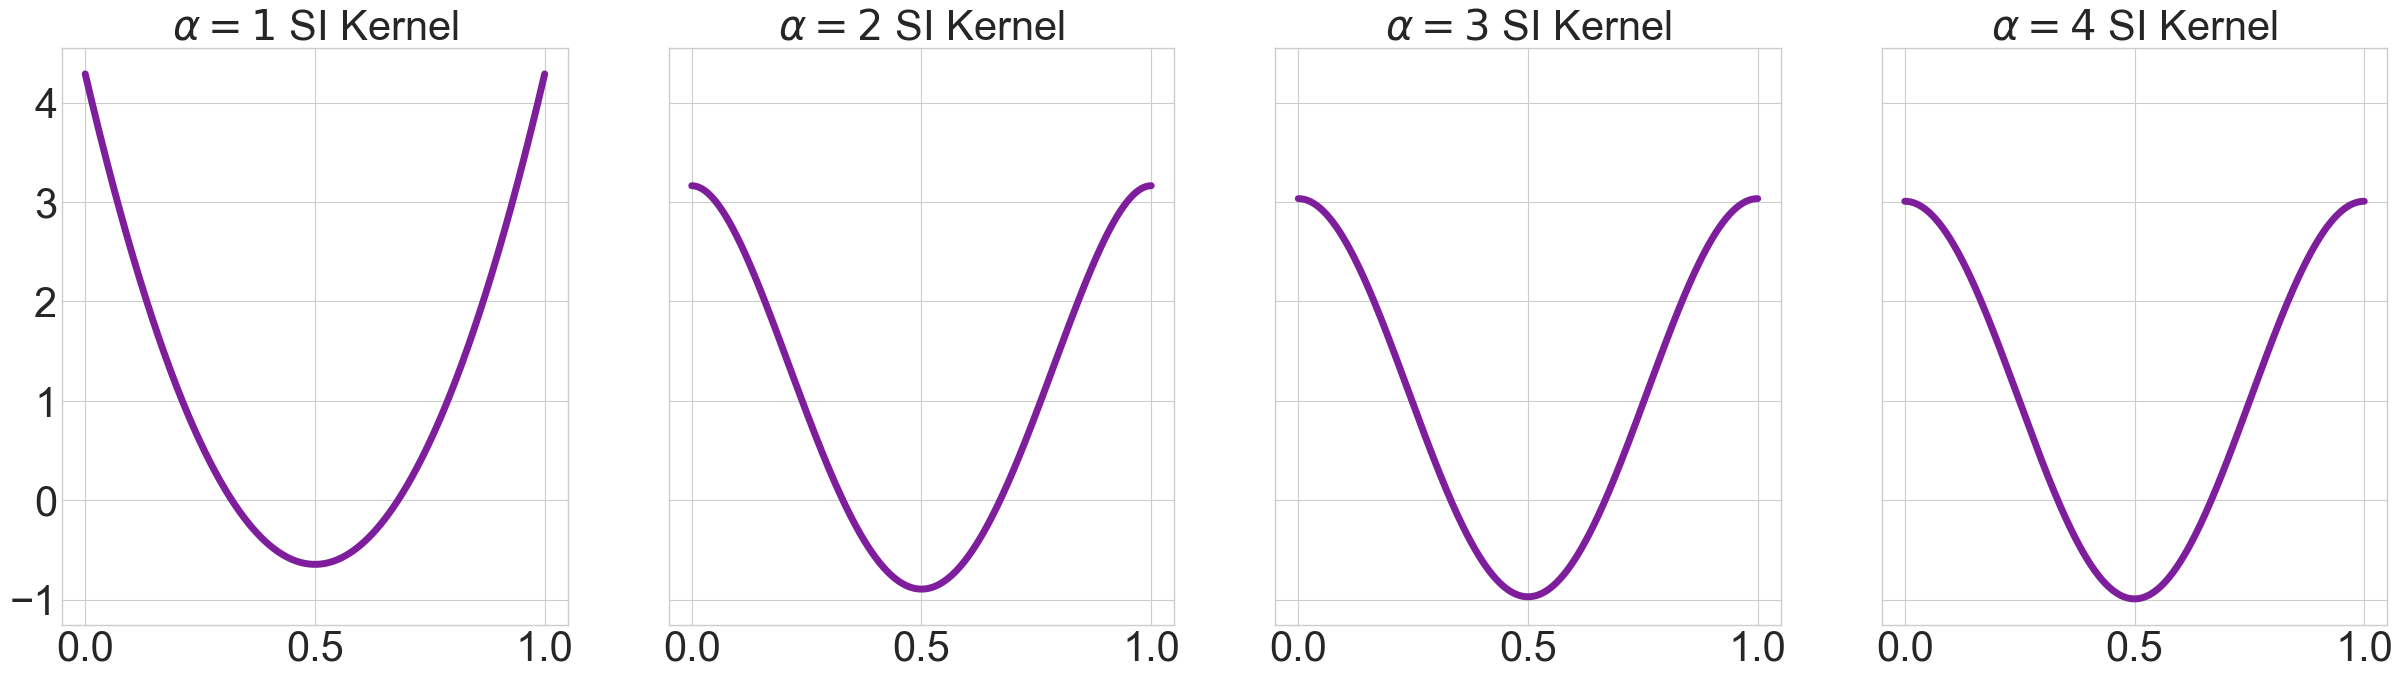

In [3]:
nalphas = 4
fig,ax = pyplot.subplots(nrows=1,ncols=nalphas,figsize=(PW,PW/nalphas),sharex=True,sharey=True)
for i in range(nalphas):
    alpha = i+1
    kernel = qp.KernelShiftInvar(d=1,alpha=alpha,torchify=True)
    kticks = kernel(torch.zeros(1),ticks[:,None]).detach()
    ax[i].plot(ticks,kticks)
    ax[i].set_title(r"$\alpha = %d$ SI Kernel"%alpha)

In [66]:
from torch import pi as PI 
from torch import sin as SIN 
from torch import cos as COS 
from torch import asin as ASIN 
from torch import acos as ACOS

class PTransform:
    def _patch01(self, x, threshold=1e-12):
        assert (-threshold<=x).all() and (x<=(1+threshold)).all(), "x.min() = %s, x.max()-1 = %s"%(x.min(),x.max()-1)
        x[x<0] = 0
        x[x>1] = 1
    def tf(self, x):
        xt = self._tf(x)
        self._patch01(xt)
        return xt
    def inv(self, xt):
        x = self._inv(xt)
        self._patch01(x) 
        return x
    def logweight(self, x):
        w_full = self._weight_full(x) 
        return torch.log(w_full).sum(-1)
    def weight(self, x):
        return torch.exp(self.logweight(x))

class IdentityPT(PTransform):
    def _tf(self, x):
        return x
    def _weight_full(self, x):
        return torch.ones_like(x)
    def _inv(self, xt):
        return xt

class TentPT(PTransform):
    def _tf(self, x):
        return 1-2*torch.abs(x-1/2)
    def _weight_full(self, x):
        return torch.ones_like(x)


class Monotone01PTTransform(PTransform):
    def _inv(self, xt, errortol=1e-8):
        x = 1/2*torch.ones_like(xt)
        error = 1/2
        t = 2
        while error>errortol:
            xthat = self.tf(x)
            flaglt = xthat<xt
            flaggt = xthat>=xt
            x[flaglt] = x[flaglt]+2**(-t)
            x[flaggt] = x[flaggt]-2**(-t)
            t += 1 
            error /= 2
        return x

class Poly0PT(Monotone01PTTransform):
    def _tf(self, x):
        return 3*x**2-2*x**3
    def _weight_full(self, x):
        return 6*x*(1-x)

class Poly1PT(Monotone01PTTransform):
    def _tf(self, x):
        return x**3*(10-15*x+6*x**2)
    def _weight_full(self, x):
        return 30*x**2*(1-x)**2
    
class Sidi0PT(Monotone01PTTransform):
    def _tf(self, x):
        return SIN(PI*x/2)**2
    def _weight_full(self, x):
        return 1/2*PI*SIN(PI*x)
    def _inv(self, y):
        return ASIN(torch.sqrt(y))*2/PI

class Sidi1PT(Monotone01PTTransform):
    def _tf(self, x):
        return x-SIN(2*PI*x)/(2*PI)
    def _weight_full(self, x):
        return 2*SIN(PI*x)**2

class Sidi2PT(Monotone01PTTransform):
    def _tf(self, x):
        return (2+COS(PI*x))*SIN(PI*x/2)**4
    def _weight_full(self, x):
        return 3/4*PI*SIN(PI*x)**3

class Sidi3PT(Monotone01PTTransform):
    def _tf(self, x):
        return (12*PI*x-8*SIN(2*PI*x)+SIN(4*PI*x))/(12*PI)
    def _weight_full(self, x):
        return 8/3*SIN(PI*x)**4

class Sidi4PT(Monotone01PTTransform):
    def _tf(self, x):
        return 1/4*(19+18*COS(PI*x)+3*COS(2*PI*x))*SIN(PI*x/2)**6
    def _weight_full(self, x):
        return 15/16*PI*SIN(PI*x)**5

/var/folders/xk/w1s5c54x0zv90dgqk3vpmbsw004hmz/T/ipykernel_76904/3379640837.py:37: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[1,i].set_yscale("log",base=10)


     IdentityPT:	 pcmean = 0.08864    pcstd = 4.8e-05    l2rerror_h = 6.3e-02    l2rerror_y = 1.3e-02   
        Sidi0PT:	 pcmean = 0.08908    pcstd = 1.4e-05    l2rerror_h = 4.3e-03    l2rerror_y = 1.9e-04   
        Sidi1PT:	 pcmean = 0.08901    pcstd = 4.6e-05    l2rerror_h = 7.1e-03    l2rerror_y = 3.3e-03   
        Poly0PT:	 pcmean = 0.08909    pcstd = 1.4e-05    l2rerror_h = 4.7e-03    l2rerror_y = 4.8e-04   
        Poly1PT:	 pcmean = 0.08902    pcstd = 2.1e-04    l2rerror_h = 6.5e-03    l2rerror_y = 2.7e-03   


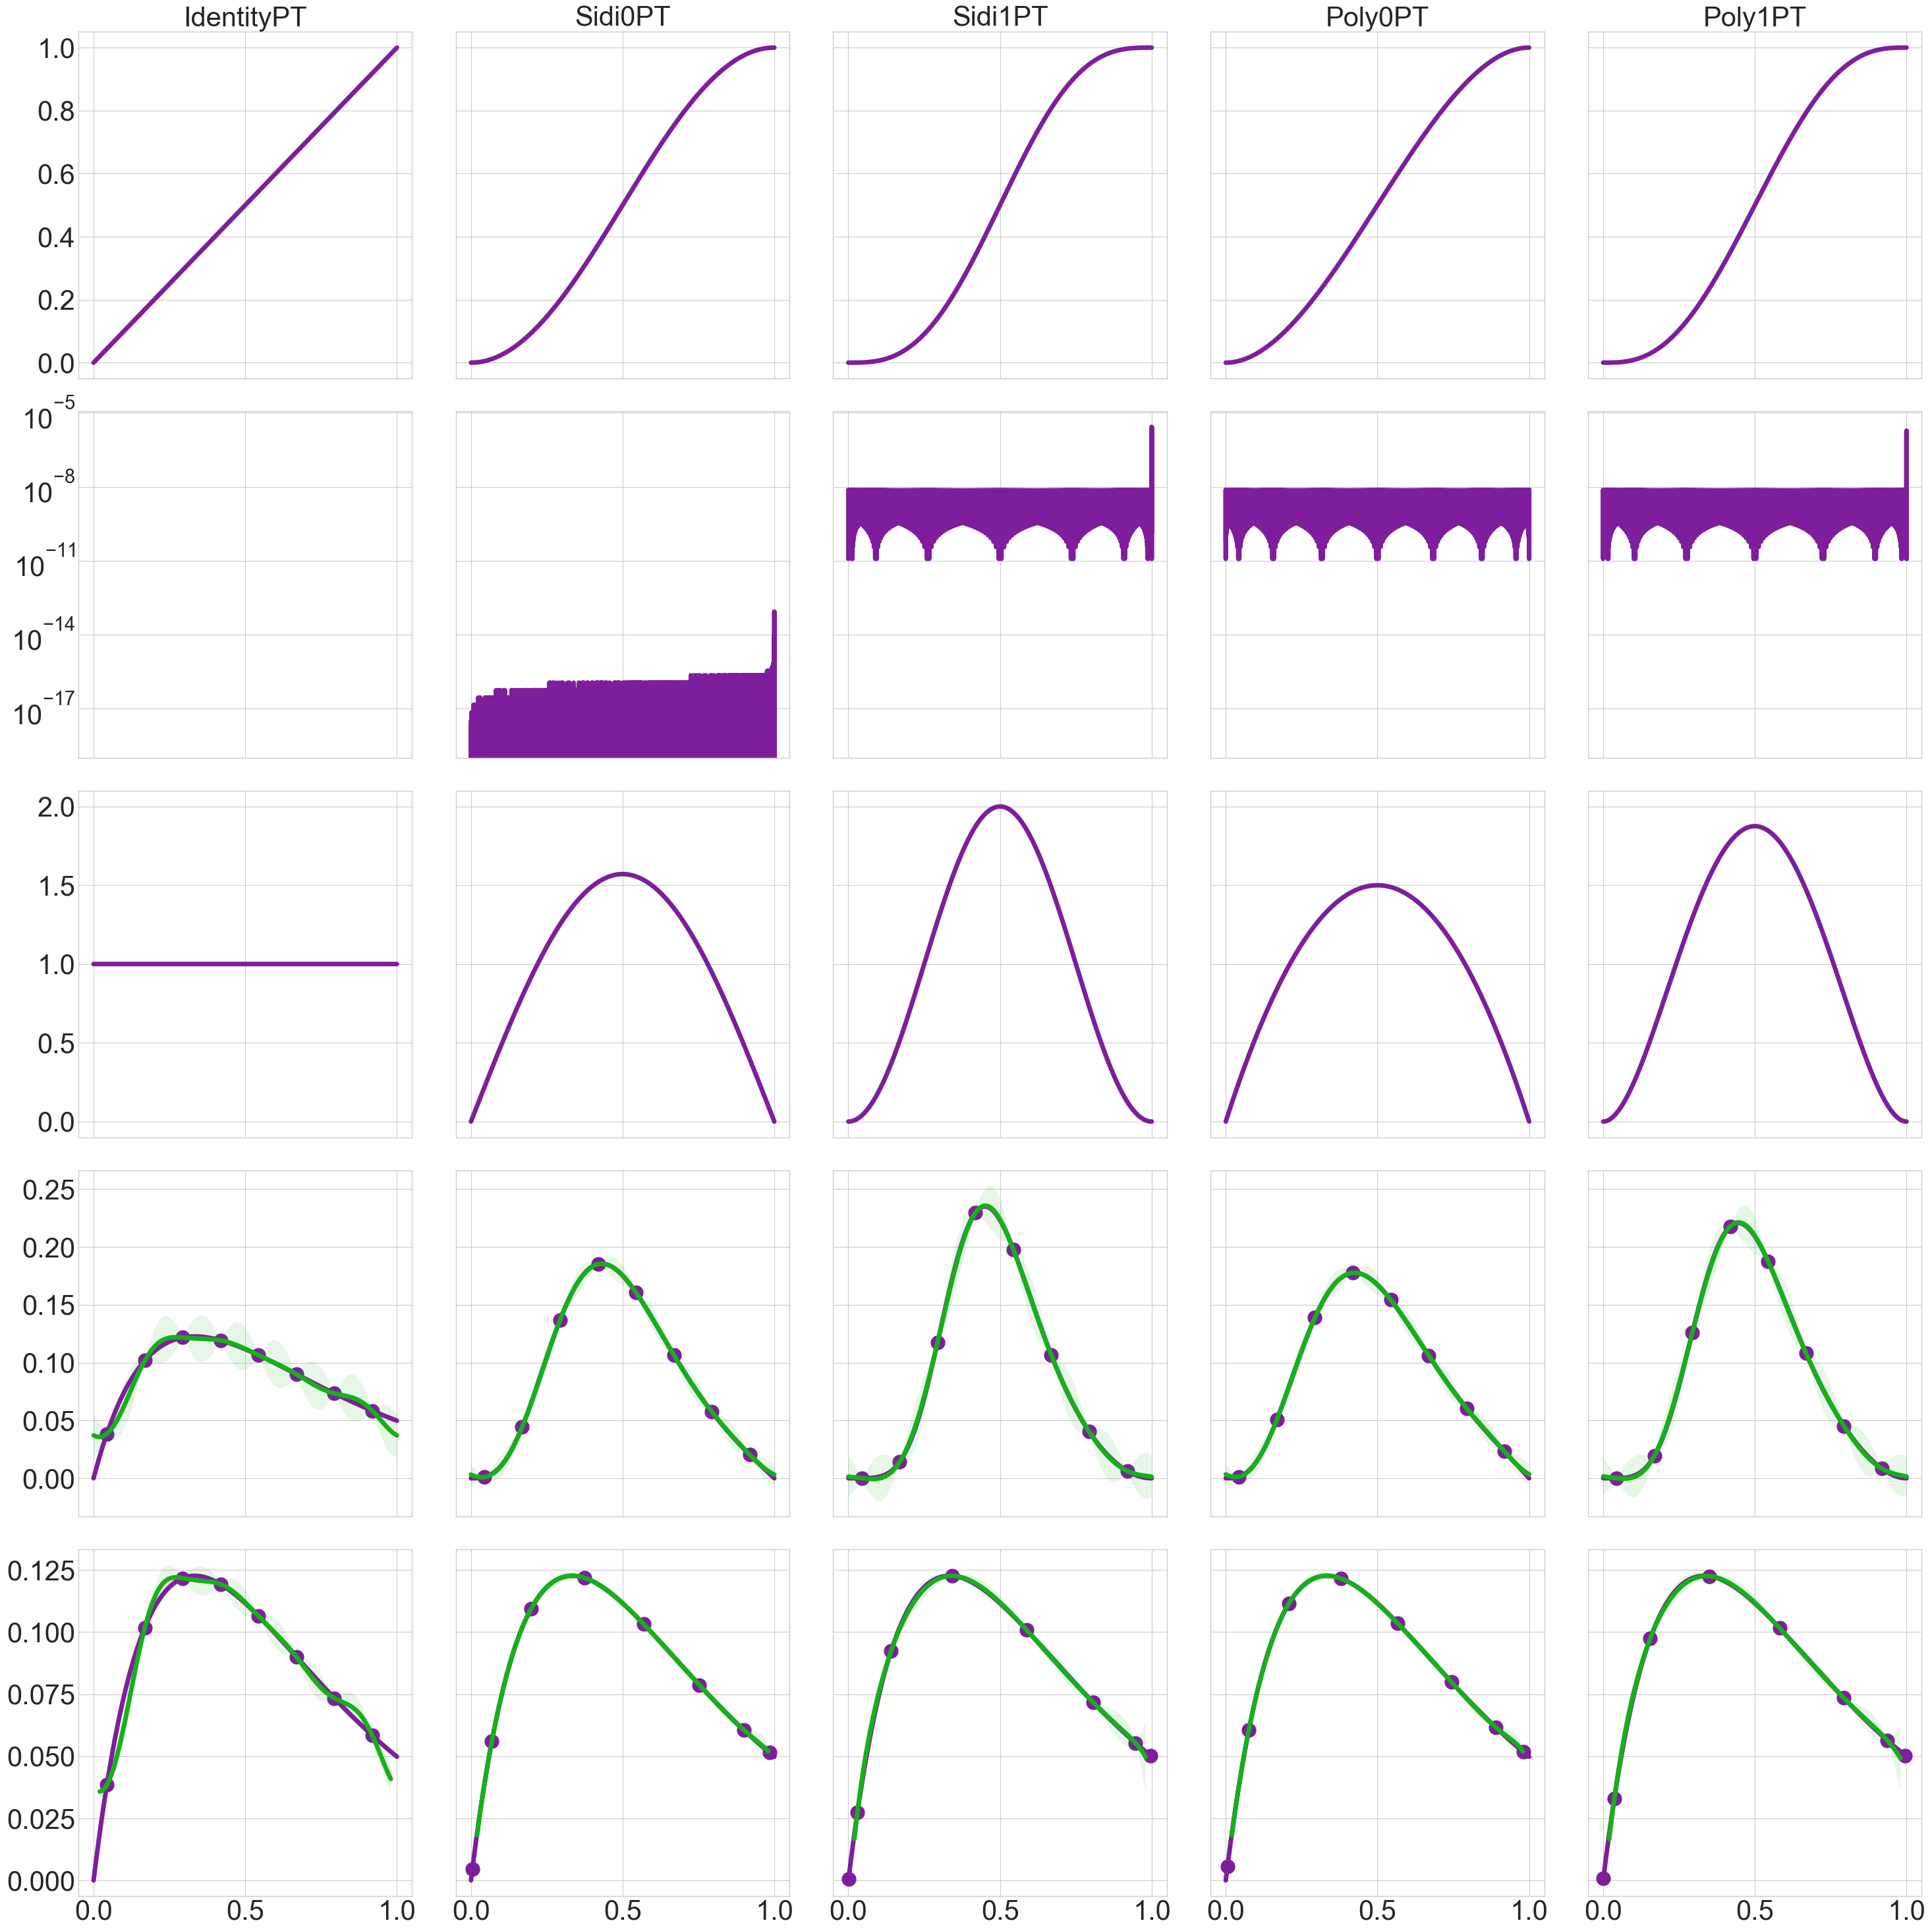

In [69]:
def f(x):
    assert x.ndim==2 and x.shape[-1]==1
    x0 = x[:,0]
    # y = x0*torch.sin(2*PI*x0)
    # y = x0*torch.exp(x0)
    y = x0*torch.exp(-3*x0)
    return y
ptransforms = [
    IdentityPT(),
    # TentPT(),
    Sidi0PT(),
    Sidi1PT(),
    # Sidi2PT(),
    # Sidi3PT(),
    # Sidi4PT(),
    Poly0PT(),
    Poly1PT(),
]
yticks = f(ticks)
nrows = 5
fig,ax = pyplot.subplots(nrows=nrows,ncols=len(ptransforms),figsize=(PW,PW/len(ptransforms)*nrows),sharex=True,sharey="row")
ax = np.atleast_2d(ax).reshape((nrows,len(ptransforms)))
for i,pt in enumerate(ptransforms):
    pt = ptransforms[i]
    ptname = type(pt).__name__
    z = pt.tf(ticks)
    tickweight = pt.weight(ticks)
    hticks = tickweight*f(z)
    if hasattr(pt,"_inv"):
        xtickshat = pt.inv(z)
        absdiffs = torch.abs(ticks-xtickshat)
        if not torch.allclose(ticks,xtickshat):
            maxabsdiffs = absdiffs.max()
            where_maxabsdiff = torch.where(absdiffs==maxabsdiffs)
            #warnings.warn("max abs difference = %.2e at %s"%(maxabsdiffs,where_maxabsdiff))
        ax[1,i].plot(z,absdiffs,label=ptname)
        ax[1,i].set_yscale("log",base=10)
    fgp = fastgps.FastGPLattice(
        kernel = qp.KernelShiftInvar(
            d = 1,
            alpha = 3,
            torchify = True, 
        ),
        seqs = qp.Lattice(seed=7),
    )
    zquery = fgp.get_x_next(2**3)
    xquery = pt.tf(zquery)
    yquery = f(xquery)
    weight = pt.weight(zquery)
    hquery = weight*yquery
    fgp.add_y_next(hquery)
    fgp.fit(verbose=0)
    htick_pmean,htick_pvar,_,htick_ci_low,htick_ci_high = fgp.post_ci(ticks)
    zticks = pt.inv(ticks)
    ztickweights = pt.weight(zticks)
    ytick_pmean = fgp.post_mean(zticks)/ztickweights
    ytick_pstd = torch.sqrt(fgp.post_var(zticks)/ztickweights**2)
    ytick_ci_low = ytick_pmean-Z*ytick_pstd
    ytick_ci_high = ytick_pmean+Z*ytick_pstd
    l2rerror_h = torch.linalg.norm(htick_pmean-hticks)/torch.linalg.norm(hticks)
    l2rerror_y = torch.linalg.norm((ytick_pmean-yticks)[1000:-1000])/torch.linalg.norm(yticks)
    print("%15s:\t pcmean = %-10.5f pcstd = %-10.1e l2rerror_h = %-10.1e l2rerror_y = %-10.1e"%(ptname,fgp.post_cubature_mean(),torch.sqrt(fgp.post_cubature_var()),l2rerror_h,l2rerror_y))
    ax[0,i].plot(ticks,z[:,0])
    ax[2,i].plot(ticks,tickweight)
    ax[3,i].plot(ticks,hticks)
    ax[3,i].plot(ticks,htick_pmean)
    ax[3,i].scatter(zquery,hquery)
    ax[3,i].fill_between(ticks[:,0],htick_ci_low,htick_ci_high,alpha=.1)
    ax[4,i].plot(ticks,yticks)
    ax[4,i].plot(ticks[100:-100],ytick_pmean[100:-100])
    ax[4,i].scatter(xquery,yquery)
    ax[4,i].fill_between(ticks[100:-100,0],ytick_ci_low[100:-100],ytick_ci_high[100:-100],alpha=.1)
    ax[0,i].set_title(ptname)
fig.tight_layout()